# Tutorial - Running GUS in Amsterdam.
A demo of a minimal flow of GUS process in Amsterdam. Data Source: https://maps.amsterdam.nl

For more advanced use cases, please see upcoming article. For more structured experiment and scenario analyis plese see model sepcification and code documentation within docs/ folder. 

In [1]:
# Install the GUS framework.

import sys
!{sys.executable} -m pip install pyGus==1.0

In [2]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 3
%matplotlib inline
from pkg_resources import resource_filename
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, json
import pkgutil
import pprint
pp = pprint.PrettyPrinter(indent=1)
sns.set_theme()


### 0. Importing GUS modules

In [3]:
from pygus.gus.models import Urban
from pygus.gus.utilities import get_raster_data, latlng_to_xy, raster_grid


## 1. Initilisation
### 1.1 Importing data on site, tree populations, experiment parameters

In [4]:
# File that holds site/city other geolocated data and parameters
fname_config_site = resource_filename("pygus", "gus/inputs/site.json")

# File that include tree species specific parameters
fname_config_allometrics = resource_filename("pygus", "gus/inputs/allometrics.json")

# File that holds experiment parameters
fname_scenario_params = resource_filename("pygus", "gus/inputs/scenario.json")

In [5]:
f = open(fname_config_allometrics)
config_allometrics = json.loads(f.read())

In [6]:
f = open(fname_config_site)
config_site = json.loads(f.read())
pp.pprint(config_site)

{'area_impervious_in_m2': 500,
 'area_pervious_in_m2': 500,
 'area_total_in_m2': 1000,
 'area_tree_density_per_hectare': 400,
 'project_site_type': 'park',
 'weather': {'growth_season_mean': 200, 'growth_season_var': 7}}


#### 1.2 Load Trees Data, Drop unnecessary columns.

In [7]:
url = 'https://treesai-gus-public.s3.eu-west-3.amazonaws.com/inputs/amsterdam_all_trees.csv'
df_pop = pd.read_csv(url)
print("Based on the source, there are {} Trees in the public Amsterdam Trees Dataset.".format(len(df_pop)))

Based on the source, there are 259431 Trees in the public Amsterdam Trees Dataset.


In [8]:
df_pop = df_pop[['OBJECTNUMMER', 'Soortnaam_WTS', 'Boomhoogte', 'RADIUS', 'LNG', 'LAT']]
df_pop = df_pop.rename({
    'OBJECTNUMMER': 'id',
    'Soortnaam_WTS': 'species',
    'Boomhoogte': 'height',
    'RADIUS': 'radius',
    'LNG': 'lng',
    'LAT': 'lat'
}, axis=1)

In [9]:
df_pop.set_index('id')
df_pop['dbh'] = df_pop['radius'] * 2.54
df_pop.tail()

,id,species,height,radius,lng,lat,dbh
259426,259427,Acer pseudoplatanus,18 tot 24 m.,7,4.968736,52.298498,17.78
259427,259428,Acer campestre,9 tot 12 m.,3,4.968974,52.298392,7.62
259428,259429,Acer pseudoplatanus,18 tot 24 m.,7,4.969281,52.298189,17.78
259429,259430,Carpinus betulus,9 tot 12 m.,3,4.967459,52.300042,7.62
259430,259431,Acer campestre,12 tot 15 m.,4,4.967483,52.300068,10.16


#### 1.3 Take avg. Height

In [10]:
import re
df_pop = df_pop[df_pop['height'] != 'Onbekend']

df_pop.tail()

,id,species,height,radius,lng,lat,dbh
259426,259427,Acer pseudoplatanus,18 tot 24 m.,7,4.968736,52.298498,17.78
259427,259428,Acer campestre,9 tot 12 m.,3,4.968974,52.298392,7.62
259428,259429,Acer pseudoplatanus,18 tot 24 m.,7,4.969281,52.298189,17.78
259429,259430,Carpinus betulus,9 tot 12 m.,3,4.967459,52.300042,7.62
259430,259431,Acer campestre,12 tot 15 m.,4,4.967483,52.300068,10.16


In [11]:
def get_average_height(height_string):
    """
    Extracts the average height from a string of the format 'X tot Y m'.
    """
    matches = re.findall(r'\d+', height_string)
    return sum(map(int, matches)) / len(matches)

df_pop['height'] = df_pop['height'].apply(get_average_height)

df_pop.tail()

,id,species,height,radius,lng,lat,dbh
259426,259427,Acer pseudoplatanus,21.0,7,4.968736,52.298498,17.78
259427,259428,Acer campestre,10.5,3,4.968974,52.298392,7.62
259428,259429,Acer pseudoplatanus,21.0,7,4.969281,52.298189,17.78
259429,259430,Carpinus betulus,10.5,3,4.967459,52.300042,7.62
259430,259431,Acer campestre,13.5,4,4.967483,52.300068,10.16


#### 1.4 Map LAT,LNG to x,y POS on MESA Grid.

In [12]:
df_pop = df_pop.apply(latlng_to_xy, axis=1)

In [13]:
minx = min(df_pop.xpos)
miny = min(df_pop.ypos)
df_pop = df_pop.apply(lambda row: raster_grid(row, minx, miny, 100), axis=1)
df_pop.tail()

,id,species,height,radius,lng,lat,dbh,xpos,ypos,gus_x,gus_y
259426,259427,Acer pseudoplatanus,21.0,7,4.968736,52.298498,17.78,634247.369246,5.796064e+06,145,20
259427,259428,Acer campestre,10.5,3,4.968974,52.298392,7.62,634263.917424,5.796053e+06,146,20
259428,259429,Acer pseudoplatanus,21.0,7,4.969281,52.298189,17.78,634285.463792,5.796031e+06,146,20
259429,259430,Carpinus betulus,10.5,3,4.967459,52.300042,7.62,634155.632591,5.796233e+06,145,22
259430,259431,Acer campestre,13.5,4,4.967483,52.300068,10.16,634157.190330,5.796236e+06,145,22


In [14]:
url = 'https://treesai-gus-public.s3.eu-west-3.amazonaws.com/inputs/species_list_amsterdam.csv'
df = pd.read_csv(url)
df = df.rename(columns={'Species': 'species'})
df.tail()

,species,Familia,Category
1084,Zelkova serrata,Ulmaceae,Deciduous
1085,Zelkova serrata `Flekova`,Ulmaceae,Deciduous
1086,Zelkova serrata `Variegata`,Ulmaceae,Deciduous
1087,Zelkova serrata `Village Green`,Ulmaceae,Deciduous
1088,Ziziphus jujuba,Rhamnaceae,Deciduous


### 2. Data Prep

Merge the two dataframes on the 'species' column
Map specific Tree species to their belonging categories 
to be able to use their generic allometric equations.


In [15]:
merged_df = pd.merge(df, df_pop, on='species')
merged_df.columns
df_pop = merged_df[['id','Category', 'height', 'dbh', 'gus_x', 'gus_y']]
df_pop.tail()


,id,Category,height,dbh,gus_x,gus_y
250586,2370,Deciduous,6.0,2.54,124,70
250587,86007,Deciduous,13.5,10.16,82,53
250588,131250,Deciduous,7.5,5.08,132,69
250589,2697,Deciduous,6.0,2.54,125,73
250590,27546,Deciduous,6.0,2.54,86,67


In [16]:
df_pop = df_pop.rename(columns={
    'Category': 'species',
    'gus_x': 'xpos',
    'gus_y': 'ypos'
})
df_pop.tail()

In [17]:
f = open(fname_scenario_params)
scenario_params = json.loads(f.read())
pp.pprint(scenario_params)

{'is_crownsunexposure_fixed': 1,
 'maintenance_scope': 2,
 'time_horizon_years': 50}


In [18]:
# Distribute the conditions of Trees over the df.
conditions = ["fair", "good", "excellent"] * (len(df_pop) // 3) + ["good"]
df_pop["condition"] = conditions


In [19]:
from datetime import  datetime
print(datetime.now())


2023-05-11 14:17:50.785764


In [21]:
# df_pop['species'].isna().sum() -- 368, deleting those for this case now.
df_pop.dropna(subset=['species'], inplace=True)
df_pop.tail()

,id,species,height,dbh,xpos,ypos,condition
250586,2370,Deciduous,6.0,2.54,124,70,excellent
250587,86007,Deciduous,13.5,10.16,82,53,fair
250588,131250,Deciduous,7.5,5.08,132,69,good
250589,2697,Deciduous,6.0,2.54,125,73,excellent
250590,27546,Deciduous,6.0,2.54,86,67,good


### 1.2 Creating a digital twin of the site

In [22]:
site = Urban(df_pop,
            fname_config_allometrics,
            fname_config_site,
            scenario_params)

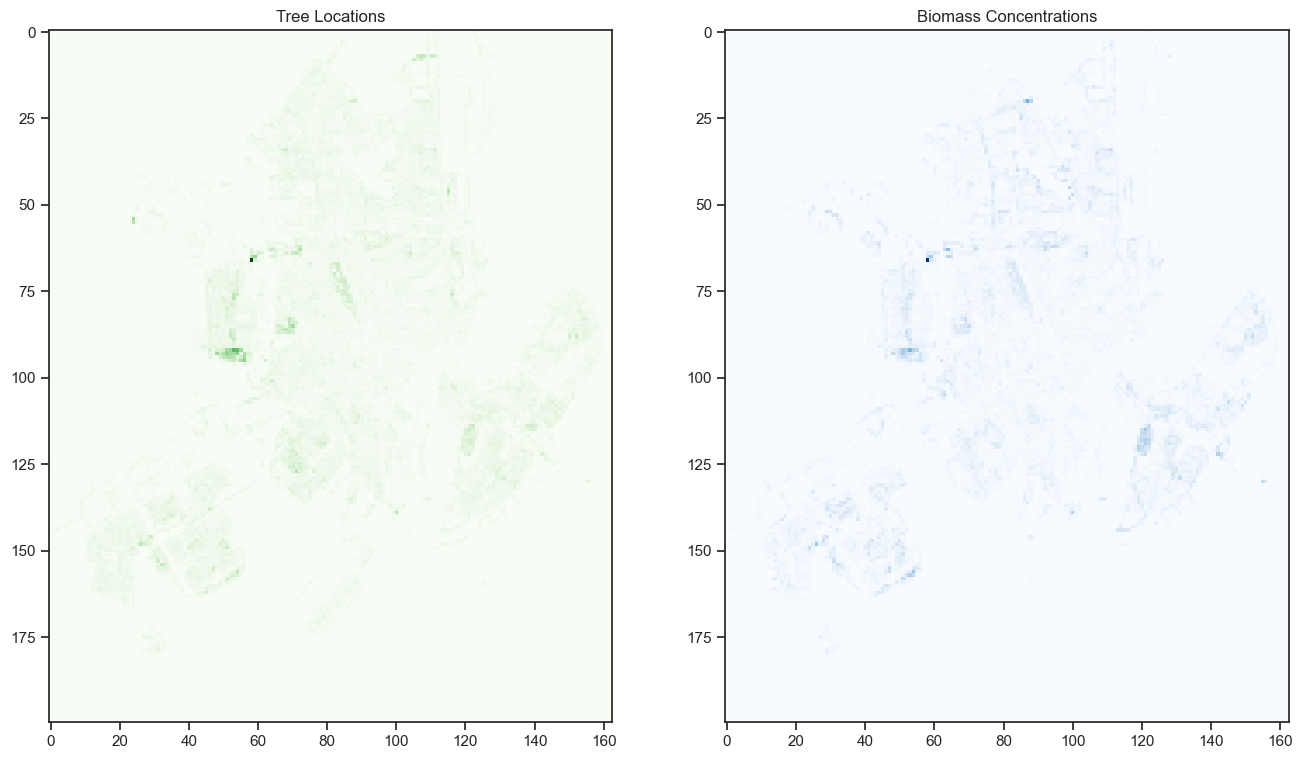

In [23]:
initial_locations = get_raster_data(site, counts=True)
initial_biomass = get_raster_data(site, var='biomass')

sns.set_style("ticks")
fig = plt.figure(figsize=(16,12))
plt.subplot(121)
plt.imshow(initial_locations, cmap='Greens')
plt.title("Tree Locations")
plt.subplot(122)
plt.title("Biomass Concentrations")
plt.imshow(initial_biomass, cmap='Blues')
#plt.colorbar(label = 'Biomass - Kg')
plt.show()


### 2. Running the scenario


In [24]:
for i in range(scenario_params['time_horizon_years']):
    site.step()


## 3. Analysis

### 3.1 Individual tree level inspections



In [25]:
# Tree level individual variables
df_out_tree = site.datacollector.get_agent_vars_dataframe()
# df_out_tree.to_csv("trees_yearly.json", index=True)
df_out_tree.tail()

species       dbh    height    crownH    crownW  canopy_overlap  \
Step AgentID                                                                   
50   443209   decidu  2.656694  4.235919  2.339384  2.053749             0.0   
     443210   decidu  3.194531  4.682084  2.504542  2.193405             0.0   
     443211   decidu  3.326539  4.786210  2.544875  2.227539             0.0   
     443212   decidu  3.305128  4.769451  2.538338  2.222006             0.0   
     443213   decidu  3.340132  4.796823  2.549023  2.231050             0.0   

               cle  condition   dieback   biomass  seq    carbon  deroot  \
Step AgentID                                                               
50   443209   0.56  excellent  0.004268  2.133963  0.0  1.066982     0.0   
     443210   0.56  excellent  0.008385  3.231112  0.0  1.615556     0.0   
     443211   0.56  excellent  0.001429  3.539349  0.0  1.769674     0.0   
     443212   0.56  excellent  0.008070  3.488292  0.0  1.744146     0.0   
     443213   0.56  excellent  0.004286  3.571975  0.0  1.785988     0.0   

              detrunk  mulched  burnt coordinates  
Step AgentID                                       
50   443209       0.0      0.0    0.0   (103, 70)  
     443210       0.0      0.0    0.0   (110, 84)  
     443211       0.0      0.0    0.0    (66, 58)  
     443212       0.0      0.0    0.0   (46, 107)  
     443213       0.0      0.0    0.0   (113, 90)

In [33]:
Specific_Tree = df_out_tree.xs(259000, level="AgentID")
Specific_Tree.tail()

,species,dbh,height,crownH,crownW,canopy_overlap,cle,condition,dieback,biomass,seq,carbon,deroot,detrunk,mulched,burnt,coordinates
Step,,,,,,,,,,,,,,,,,
46,decidu,20.794221,12.952444,7.173064,6.244599,1.0,0.111884,replaced,1.0,218.769064,0.0,109.384532,0.0,0.0,0.0,0.0,"(118, 136)"
47,decidu,20.794221,12.952444,7.173064,6.244599,1.0,0.111884,replaced,1.0,218.769064,0.0,109.384532,0.0,0.0,0.0,0.0,"(118, 136)"
48,decidu,20.794221,12.952444,7.173064,6.244599,1.0,0.111884,replaced,1.0,218.769064,0.0,109.384532,0.0,0.0,0.0,0.0,"(118, 136)"
49,decidu,20.794221,12.952444,7.173064,6.244599,1.0,0.111884,replaced,1.0,218.769064,0.0,109.384532,0.0,0.0,0.0,0.0,"(118, 136)"
50,decidu,20.794221,12.952444,7.173064,6.244599,1.0,0.111884,replaced,1.0,218.769064,0.0,109.384532,0.0,0.0,0.0,0.0,"(118, 136)"


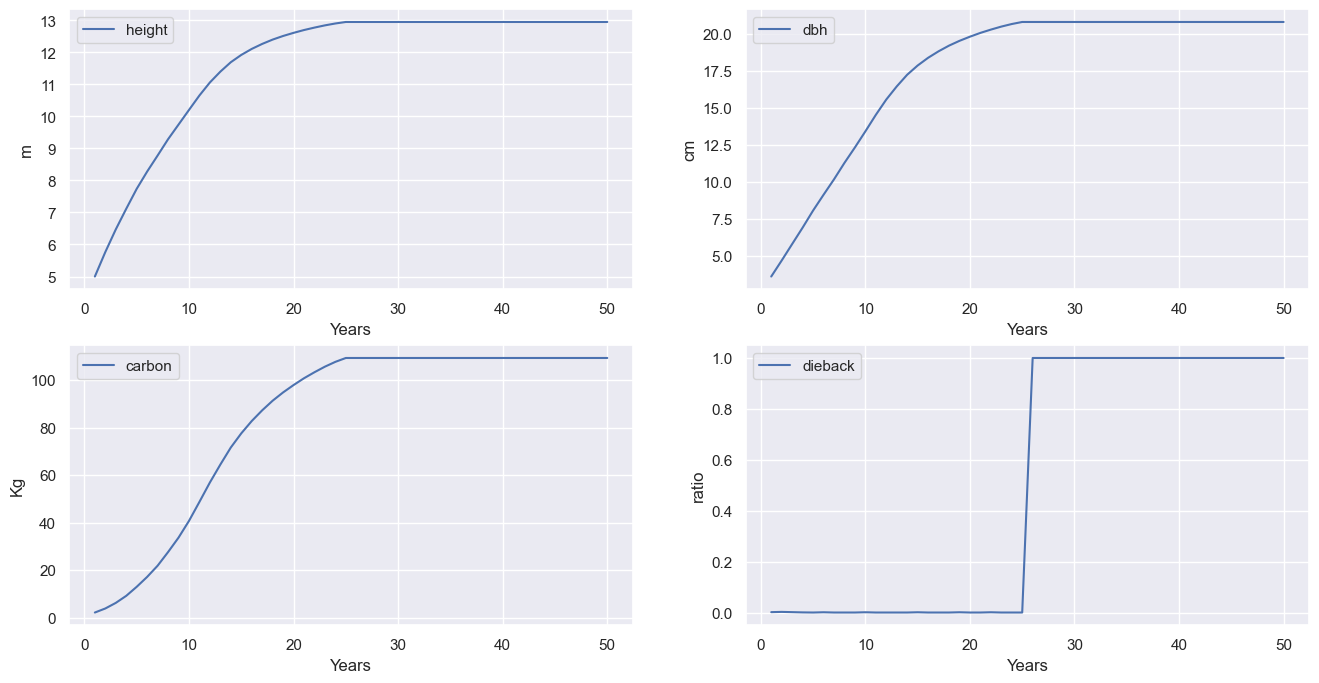

In [34]:
sns.set_theme()
fig = plt.figure(figsize=(16,8))
plt.subplot(221)
Specific_Tree.height.plot()
plt.xlabel('Years')
plt.ylabel('m')
plt.legend()
plt.subplot(222)
Specific_Tree.dbh.plot()
plt.xlabel('Years')
plt.ylabel('cm')
plt.legend()
plt.subplot(223)
Specific_Tree.carbon.plot()
plt.xlabel('Years')
plt.ylabel('Kg')
plt.legend()
plt.subplot(224)
Specific_Tree.dieback.plot()
plt.xlabel('Years')
plt.ylabel('ratio')
plt.legend()
plt.show()

In [35]:
# Site level aggregate variables
df_out_site = site.datacollector.get_model_vars_dataframe()
df_out_site.tail()

,Storage,Seq,Released,Alive,Dead,Critical,Dying,Poor,Replaced,Seq_std
45,3.655157e+07,461952.271809,224822.834741,246576,3647,0,0,0,169090,3.523956
46,3.700580e+07,448935.294563,225930.397666,246584,3639,0,0,0,172737,3.409219
47,3.745606e+07,445014.389049,222783.358138,246587,3636,0,0,0,176376,3.361031
48,3.786623e+07,404919.138202,234964.094079,246453,3770,0,0,0,180012,3.050119
49,3.831842e+07,446720.459312,235577.722289,246423,3800,0,0,0,183782,3.343381


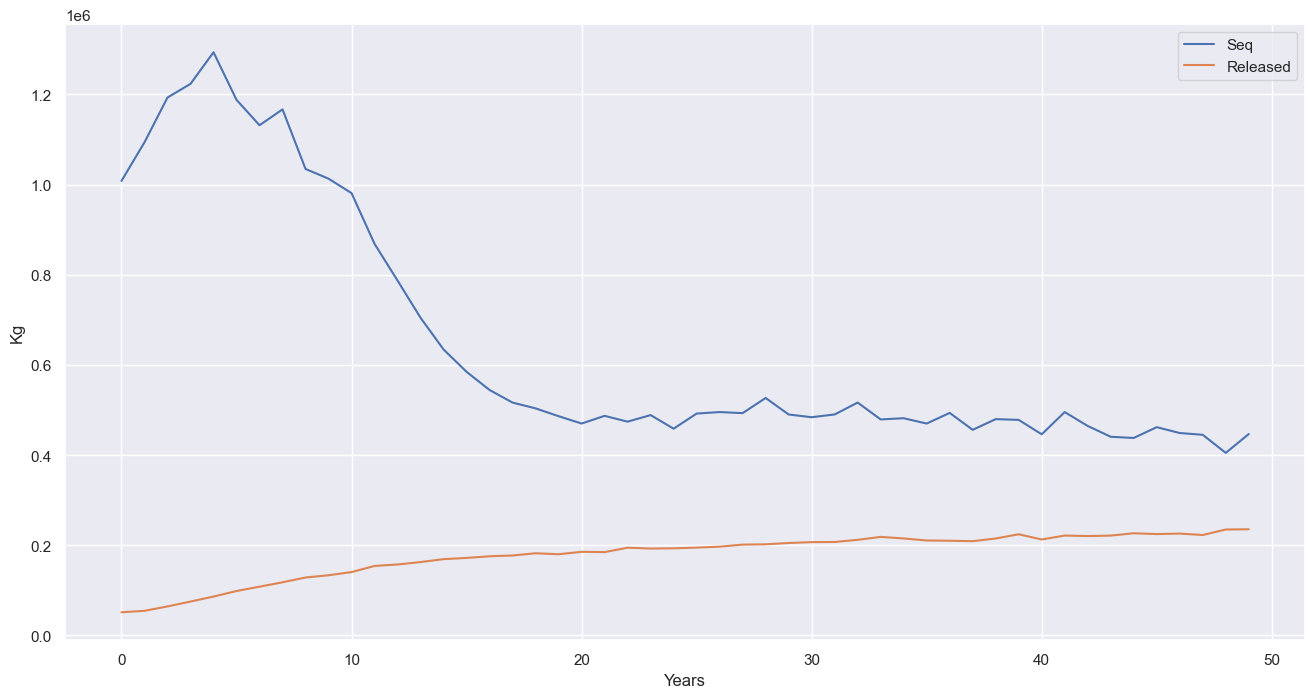

In [36]:
fig = plt.figure(figsize=(16,8))
df_out_site.Seq.plot()
df_out_site.Released.plot()
plt.xlabel('Years')
plt.ylabel('Kg')
plt.legend()
plt.show()

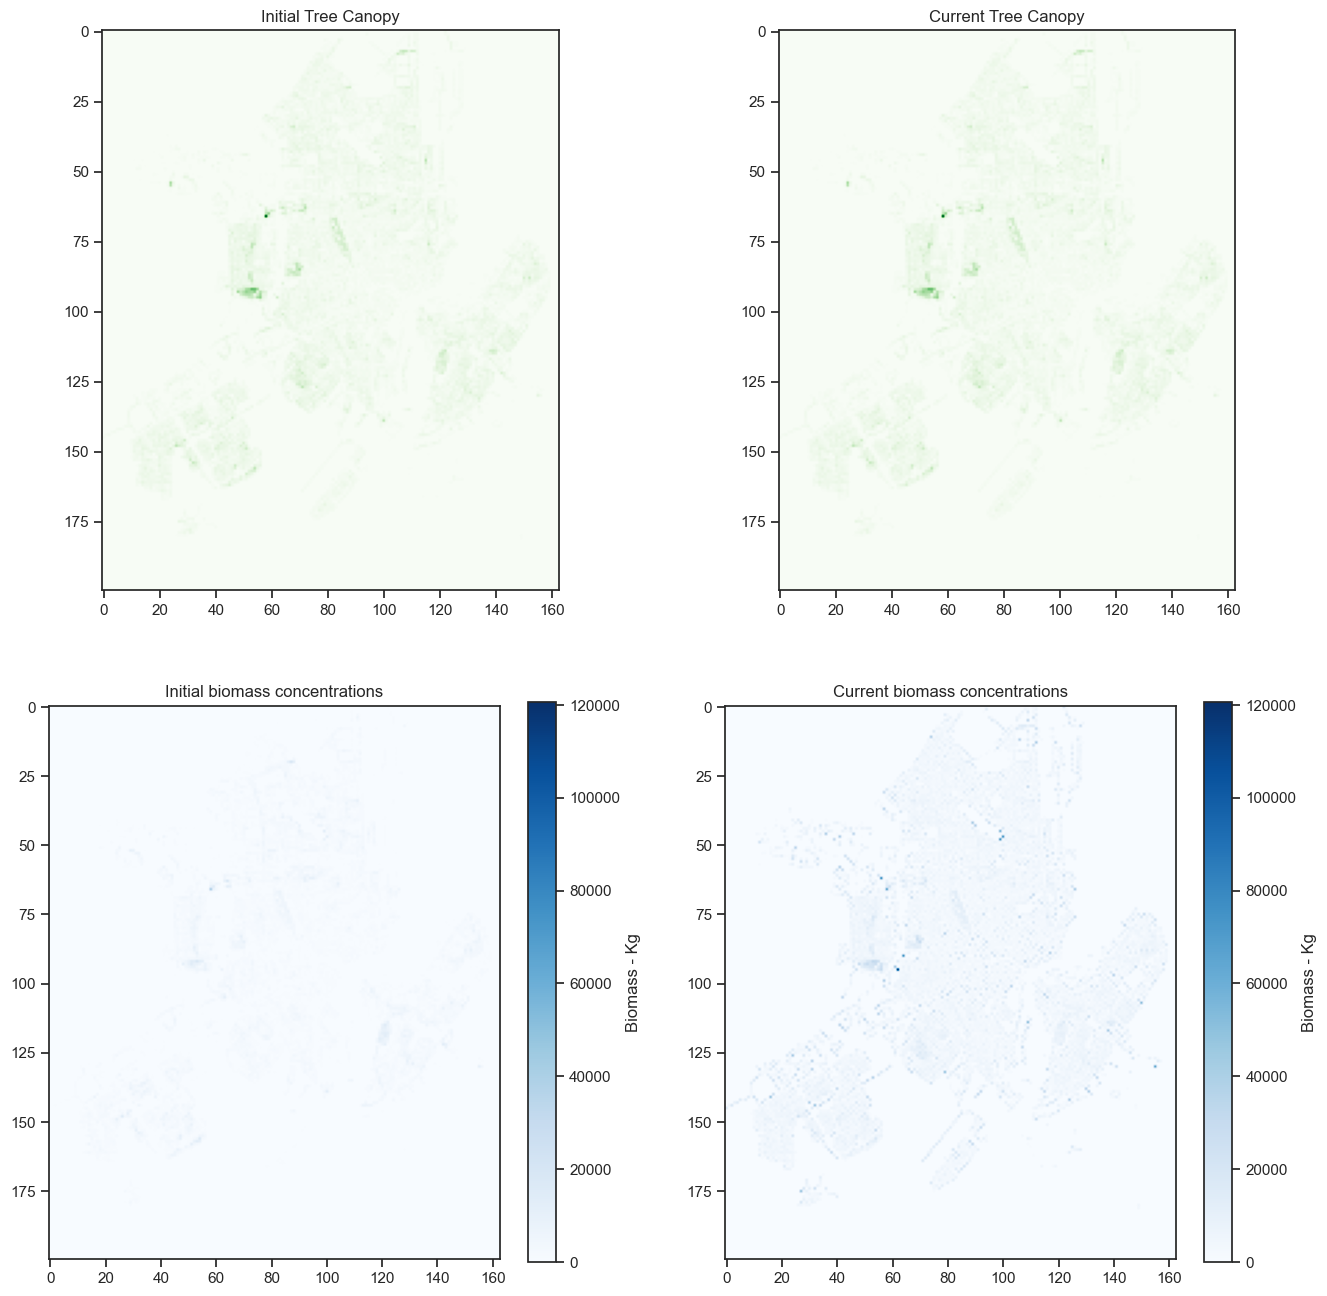

In [37]:
locations = get_raster_data(site, counts=True)
biomass = get_raster_data(site, var='biomass')

sns.set_style("ticks")
fig = plt.figure(figsize=(16,16))
plt.subplot(221)
plt.imshow(initial_locations, cmap='Greens')
plt.title("Initial Tree Canopy")

plt.subplot(222)
plt.imshow(locations, cmap='Greens')
plt.title("Current Tree Canopy")

plt.subplot(223)
plt.title("Initial biomass concentrations")
plt.imshow(initial_biomass, cmap='Blues', vmin=0, vmax=biomass.max())
plt.colorbar(label = 'Biomass - Kg')

plt.subplot(224)
plt.title("Current biomass concentrations")
plt.imshow(biomass, cmap='Blues')
plt.colorbar(label = 'Biomass - Kg')
plt.show()